In [46]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import datetime
import time
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
path_dataset = "data_train.csv"
ratings_data = load_data(path_dataset)
print('Shape of ratings matrix:',ratings_data.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


We try to analyze the data before proceeding further by looking at the distribution of number of ratings available for different users and different items.

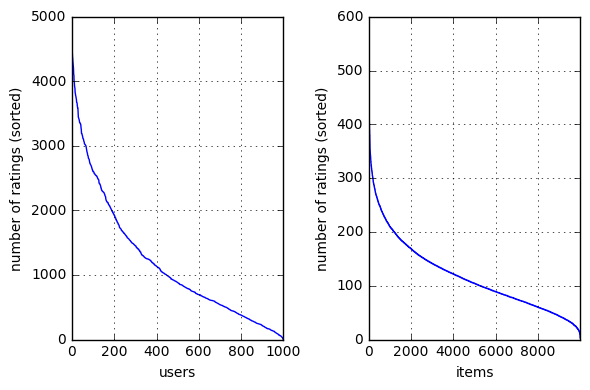

min # of items per user = 8, min # of users per item = 3.


In [48]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings_data)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Pre-processing

The data seems to have no users or items that have all entries as zero i.e. every user or item has atleast one non-zero rating. Since running SGD on the original data (10000 x 1000) takes a lot of time (estimated: 10 mins for 1 iteration of SGD), we will work on a subset of the data for the purpose of finding the right hyper-parameters - a submatrix of dimensions 1000 x 100 of the original data matrix. Since this submatrix may have some rows or columns with all zero entries, we need to remove such rows and columns. 

In the next step of pre-processing we subtract from each non-zero entry of the ratings matrix - the average of the mean of all the ratings for this particular user (user mean) and the 
mean of all the ratings for this particular item (item mean).

$$  r'_{ui} =  r_{ui} - \frac{(\mu_{u} + \mu_{i})}{2}  $$
where $\mu_{u}$ is the mean of ratings for user $u$

and $\mu_{i}$ is the mean of ratings for item $i$

In [5]:
np.random.seed(77)


In [6]:
# Chose submatrix from the 10000x1000 matrix
submatrix_mode = True #False #True #False
    
ratings = scipy.sparse.lil_matrix.todense(ratings_data)
if submatrix_mode == True:
    sub_rows = np.random.randint(0, ratings.shape[0], 2000)
    sub_cols = np.random.randint(0, ratings.shape[1], 200)
    ratings = ratings[sub_rows,:]
    ratings = ratings[:,sub_cols]

In [7]:
print(ratings.shape)
print(len(ratings.nonzero()[0]))

(2000, 200)
45683


In [8]:
def remove_empty_rows_and_cols(ratings):
    """
        Remove rows and columns that have no non-zero values
        
        Arguments:
            ratings: ratings data matrix

        Returned value(s):
            ratings: data matrix after deleting the rows and columns with no non-zero values
            
    """

    del_rows = ([])
    for row in range(ratings.shape[0]):
        if len(ratings[row,:].nonzero()[0]) == 0:
            del_rows.append(row)

    ratings = np.delete(ratings,del_rows,axis=0)
    
    del_cols = ([])
    for col in range(ratings.shape[1]):
        if len(ratings[:,col].nonzero()[0]) == 0:
            del_cols.append(col)
            

    ratings = np.delete(ratings,del_cols,axis=1)
    return ratings

In [30]:
def find_mean_vectors(ratings):

    """
    Compute mean user 

    Arguments:
        ratings: ratings data matrix

    Returned value(s):
        user_mean: Array of mean user ratings
        item_mean: array of mean item ratings

    """

    # calculating the user_mean and item_mean vectors:

    # user_mean vector:

    user_mean = np.zeros((ratings.shape[1],1))

    for user_no in range(ratings.shape[1]):

        a = ratings[:,user_no].sum()
        b = np.shape(ratings[:,user_no].nonzero())[1]
        user_mean[user_no,0] = (a/b)

    # item_mean vector:

    item_mean = np.zeros((ratings.shape[0],1))

    for item_no in range(ratings.shape[0]):

        a = ratings[item_no,:].sum()
        b = np.shape(ratings[item_no,:].nonzero())[1]
        item_mean[item_no,0] = (a/b)
    print('user_mean and item_mean computed!')   
    return user_mean, item_mean

    

In [31]:
def preprocess(ratings):
    """
        Perform pre-processing on the ratings data matrix
        
        Arguments:
            ratings: ratings data matrix

        Returned value(s):
            ratings_preproc: data matrix after deleting the rows and columns with no non-zero values
            preproc_layer: Matrix that is subtracted from the data matrix to perform pre-processing 
            retrieve_layer: Matrix to be added to the data matrix to undo the pre-processing
            
    """
    user_mean, item_mean = find_mean_vectors(ratings)
   
    mask = ratings.copy()
    mask[mask>0] = 1
    
    A = ((user_mean@np.ones((1,ratings.shape[0]))).T)
    B = ((item_mean@np.ones((1,ratings.shape[1]))))
    preproc_layer = ( np.multiply(mask,A)
                     + np.multiply(mask,B) ) / 2
    
    ratings_dense = ratings
    ratings_preproc = (ratings_dense - (preproc_layer))
    retrieve_layer = (A + B)/2
    return ratings_preproc, preproc_layer, retrieve_layer

In [32]:
def find_global_mean(ratings):
    """
        Compute global mean 
        
        Arguments:
            ratings: ratings data matrix

        Returned value(s):
            global_mean: mean of all the ratings available in the data
            
    """
    global_mean = np.sum(ratings)/len(ratings.nonzero()[0])
    print(global_mean,'global_mu')
    return global_mean

In [11]:
def find_bias_vectors(ratings):
    """
        Compute mean user 
        
        Arguments:
            ratings: ratings data matrix

        Returned value(s):
            user_bias: array of user bias in the ratings
            item_bias: array of item bias in the ratings 
            
    """
    
    # calculating the user_bias and item_bias vectors:

    global_mean = np.sum(ratings)/len(ratings.nonzero()[0])
    print(global_mean,'global_mu')

    # user_bias vector:
    user_bias = np.zeros((ratings.shape[1],1))

    for user_no in range(ratings.shape[1]):

        a = ratings[:,user_no].sum()
        b = np.shape(ratings[:,user_no].nonzero())[1]
        user_bias[user_no,0] = global_mean - (a/b)

    # item_bias vector:
    item_bias = np.zeros((ratings.shape[0],1))

    for item_no in range(ratings.shape[0]):

        a = ratings[item_no,:].sum()
        b = np.shape(ratings[item_no,:].nonzero())[1]
        item_bias[item_no,0] = global_mean - (a/b)
    
    print('user_bias and item_bias computed!')   
    return global_mean, user_bias, item_bias

In [12]:
ratings = remove_empty_rows_and_cols(ratings)
ratings_preproc, preproc_layer, retrieve_layer = preprocess(ratings)
global_mean, user_bias_stored, item_bias_stored = find_bias_vectors(ratings_preproc)

user_mean and item_mean computed!
1.02659356319e-17 global_mu
user_bias and item_bias computed!


## Running SGD to generate predictions

The model we assume is of the form - 
$$ \hat r_{ui} = \mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} $$

where  $\hat r_{ui} $ stands for rating given by user $u$ for movie or item $i$

$\mu$ stands for the global mean of the available ratings

$b_{u}$ is the user bias

$b_{i}$ is the item bias

and

$\textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}$ is the inner product of the feature vector for user u and movie i

To be found by SGD: $b_{u}, b_{i},\textbf{x}_{u},\textbf{y}_{i} $ for all $u$ and $i$

The loss function to be optimized using SGD would be the following: 

$$L = \sum\limits_{u,i}(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))^{2} + 
\lambda_{xb} \sum\limits_{u} \left\Vert b_{u} \right\Vert^{2} + \lambda_{yb} \sum\limits_{i} \left\Vert b_{i} \right\Vert^{2} + \lambda_{xf} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{yf} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

We initialize the biases and the means by zeros. Other option could be to initialize with small random numbers.

In [13]:
def SGD_train(gamma,num_features,lambda_,num_epochs,ratings,change_step,param_search):
    
    """
        Run Stochastic Gradient Descent to predict ratings by matrix factorization
        
        Arguments:
            gamma: step-size for sgd
            num_features: number of latent features
            lambda_: regularization factor
            num_epochs: number of epochs (passes over the training instances)
            ratings: the ratings data matrix
            change_step: True if gamma is to be decreased to 2e-05 after 11 iterations
            param_search: True if hyper-parameters are being checked for optimal performance 

        Returned value(s):
            mat_pred: 2d array containing predictions in the normalized (pre-processed form)
            retrieve_layer: 2d array to be added to the predictions to undo the normalization 
            user_bias: array containing bias values for users 
            item_bias: array containing bias values for users 
            user_features: (W matrix) 2d array containing the 
            item_features: (Z matrix)
            rmse_train: array containing training rmse values over iterations
            rmse_test: array containing test rmse values over iterations
            
    """
    
    '''Defining hyper-parameters''' 
    
    gamma =  gamma               # Step-size for SGD
    num_features = num_features  # Number of latent features
    lambda_ = lambda_            # Lambda values (regularization parameter as shown in equation above)
    [lambda_user, lambda_item, lambda_user_bias, lambda_item_bias] = [lambda_, lambda_, lambda_, lambda_]
    num_epochs = num_epochs      # No of iterations over the entire training data
    split_ratio = 0.8            # Fraction of data (non-zero entries) in the training set

    test_mode = True
    if split_ratio == 1.0:
        test_mode = False
        
    '''Creating training and test sets as per the split ratio'''
    
    def nonzero_indices(matrix):
        nz_row, nz_col = matrix.nonzero()
        return list(zip(nz_row, nz_col))

    nonzero_indices = nonzero_indices(ratings)
    split_point = int(np.floor(len(nonzero_indices) * split_ratio))
    train_nonzero_indices = nonzero_indices[:split_point]
    test_nonzero_indices = nonzero_indices[split_point:]

    train_set = np.zeros(ratings.shape)
    test_set = np.zeros(ratings.shape)

    for i, j in train_nonzero_indices:
        train_set[i, j] = ratings[i, j]

    for i, j in test_nonzero_indices:
        test_set[i, j] = ratings[i, j]

    # find the non-zero ratings indices in the training and test data 
    nz_row, nz_col = train_set.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test_set.nonzero()
    nz_test = list(zip(nz_row,nz_col))


    '''Initializing the user biases, item biases, user features, item features by zero values'''
    
    item_features = np.zeros((train_set.shape[0],num_features))
    user_features = np.zeros((train_set.shape[1],num_features))
    
    if initialize_by_means == True:
        
        item_features = np.random.random((train_set.shape[0],num_features))
        [item_means,user_means] = find_mean_vectors(train_set)
        item_features[:,0] = item_means
        user_features = np.random.random((train_set.shape[1],num_features))
    
    user_bias = np.zeros((train_set.shape[1]))
    item_bias = np.zeros((train_set.shape[0]))

    real_train_label = np.zeros(len(nz_train))
    prediction_train = np.zeros(len(nz_train))
    rmse_train = np.zeros(num_epochs)


    '''Evaluating training and test rmse before running SGD'''
    
    global_mean = find_global_mean(ratings)
    
    mat_pred = ( global_mean*np.ones((train_set.shape)) +
                (user_bias.reshape((train_set.shape[1],1)).dot(np.ones((1,train_set.shape[0])))).T +
                (item_bias.reshape((train_set.shape[0],1)).dot(np.ones((1,train_set.shape[1])))) +
                np.dot(item_features,user_features.T) )
    
    # Adding the retrieve_layer to undo the pre-processing step
    mat_pred_for_mse = (mat_pred + retrieve_layer)

    for i in range(len(nz_train)):
        real_train_label[i] = train_set[nz_train[i][0],nz_train[i][1]] + retrieve_layer[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred_for_mse[nz_train[i][0],nz_train[i][1]]

    rmse = calculate_mse(real_train_label, prediction_train)
    if param_search == False:
        print('Train rmse with initialization: ',rmse)   
        print('gamma = ',gamma)

    if test_mode == True:

        real_test_label  = np.zeros(len(nz_test))
        prediction_test = np.zeros(len(nz_test))
        rmse_test  = np.zeros(num_epochs)

        # Printing test rmse before any update loop

        for i in range(len(nz_test)):
            real_test_label[i] = test_set[nz_test[i][0],nz_test[i][1]] + retrieve_layer[nz_test[i][0],nz_test[i][1]]
            prediction_test[i] = mat_pred_for_mse[nz_test[i][0],nz_test[i][1]]

        rmse = calculate_mse(real_test_label, prediction_test)
        if param_search == False:
            print('Test rmse with initialization: ',rmse)  

    '''Running SGD iterations'''
    for it in range(num_epochs): 
        if change_step == True:
            if it>11:
                gamma = 0.00002

#         print('Iteration No',it+1)
        
        # decrease step size
        # gamma /= 1.2

        begin = datetime.datetime.now()
        count = 0
        for d,n in nz_train:
#             count += 1
#             if count%10000 == 0:
#                 print(count)
            difference = train_set[d,n] - mat_pred[d,n]

            # Updating the W
            gradient1 = -1* (difference) * user_features[n,:]
            item_features[d,:] = item_features[d,:]*(1 - gamma*lambda_item) - gamma * gradient1


            # Updating the Z
            gradient2 = -1* (difference) * item_features[d,:]
            user_features[n,:] = user_features[n,:]*(1 - gamma*lambda_user) - gamma * gradient2

            # Updating the user_bias vector
            gradient3 = -1* (difference) 
            user_bias[n] = user_bias[n]*(1 - gamma*lambda_user_bias) - gamma * gradient3

            # Updating the item_bias vector
            gradient4 = -1* (difference)
            item_bias[d] = item_bias[d]*(1 - gamma*lambda_item_bias) - gamma * gradient4


            mat_pred[d,:] = (np.dot(user_features,item_features[d,:])
                             + user_bias
                             + item_bias[d]*np.ones((ratings.shape[1])) 
                             + global_mean*np.ones((ratings.shape[1])))

            mat_pred[:,n] = (np.dot(item_features,user_features[n,:])
                             + item_bias
                             + user_bias[n]*np.ones((ratings.shape[0]))
                             + global_mean*np.ones((ratings.shape[0])))

        mat_pred_for_mse = (mat_pred + retrieve_layer)

        #Calculating training rmse
        for i in range(len(nz_train)):
            real_train_label[i] = train_set[nz_train[i][0],nz_train[i][1]] + retrieve_layer[nz_train[i][0],nz_train[i][1]]
            prediction_train[i] = mat_pred_for_mse[nz_train[i][0],nz_train[i][1]]

        rmse = calculate_mse(real_train_label, prediction_train) 
        rmse_train[it] = rmse

        if test_mode == True:
            for i in range(len(nz_test)):
                real_test_label[i] = test_set[nz_test[i][0],nz_test[i][1]] + retrieve_layer[nz_test[i][0],nz_test[i][1]]
                prediction_test[i] = mat_pred_for_mse[nz_test[i][0],nz_test[i][1]]

            rmse_t = calculate_mse(real_test_label, prediction_test)
            rmse_test[it] = rmse_t
            
        if param_search == False:
            print("iter: {}, RMSE on training set: {}.".format(it+1, rmse))
            if test_mode == True:
                print("iter: {}, RMSE on testing set: {}.".format(it+1, rmse_t))
        end = datetime.datetime.now()
        execution_time = (end - begin).total_seconds()

        if param_search == False:
            print('Iteration runtime: ',execution_time)
#         gamma = gamma/2
    
#     plt.plot(np.arange(num_epochs),rmse_train,np.arange(num_epochs),rmse_test)
    
    return mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train

# Finding the right hyper-parameters 

### A. Varying 'step_size' parameter to find optimal value for step-size 

Trying gamma (stepsize) =  0.02
1.02659356319e-17 global_mu
Trying gamma (stepsize) =  0.002
1.02659356319e-17 global_mu
Trying gamma (stepsize) =  0.0002
1.02659356319e-17 global_mu
Trying gamma (stepsize) =  2e-05
1.02659356319e-17 global_mu


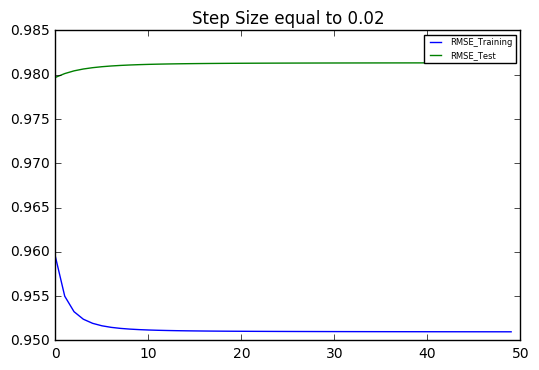

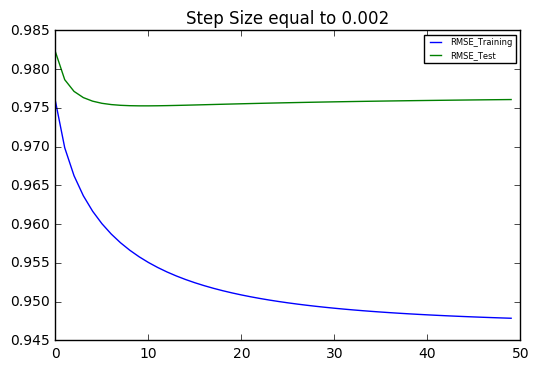

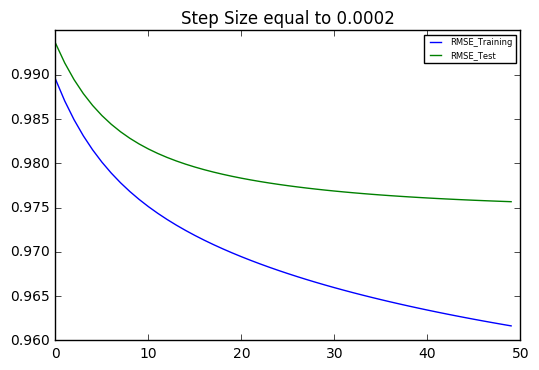

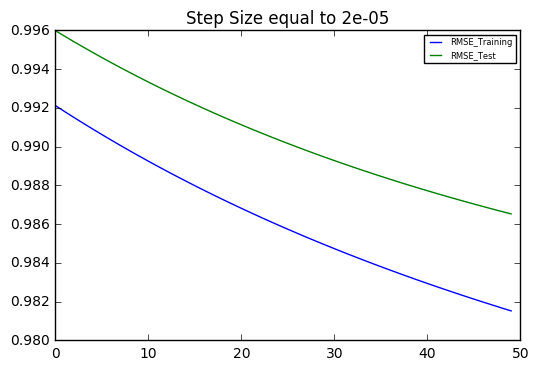

In [15]:
num_features = 50   # K in the lecture notes
lambda_ = 0
num_epochs = 50
best_gamma = 0.006
rmse_last = np.inf

gamma_list = [0.02,0.002,0.0002,0.00002]
all_mat_pred = ([])
all_rmse_test = ([])
all_rmse_train = ([])

initialize_by_means = False

for ind,gamma in enumerate(gamma_list):
    print('Trying gamma (stepsize) = ',gamma)
    [mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
        SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc,change_step = False,param_search=True))
    
    all_mat_pred.append(mat_pred + retrieve_layer)
    all_rmse_test.append(rmse_test)
    all_rmse_train.append(rmse_train)
    
    if rmse_last > rmse_test[-1]:
        best_gamma = gamma
        best_ind = ind
        rmse_last = rmse_test[-1]

for ind in range(len(gamma_list)):
    rmse_train = all_rmse_train[ind]
    rmse_test = all_rmse_test[ind]
    plt.plot(np.arange(num_epochs),rmse_train,label='RMSE_Training')
    plt.plot(np.arange(num_epochs),rmse_test,label ='RMSE_Test')
    step_size = gamma_list[ind]
    a = 'Step Size equal to ' + str(step_size)
    plt.title(a)
    plt.legend(loc='upper right',fontsize = 6)
    plt.show()
    plt.close()
    
# print('Best value obtained for the hyperparameter step size is - ',best_gamma)

Step-size of 0.002 and 0.0002 seem to work well, for the actual predictions, we stick with the value of 0.006 (slightly more than 0.002 to move a bit faster than what we see in these plot)

### B. Varying the lambdas:

Regularization: 0
1.02659356319e-17 global_mu


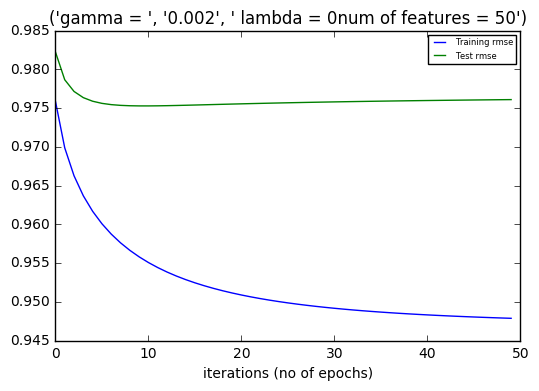

Regularization: 0.001
1.02659356319e-17 global_mu


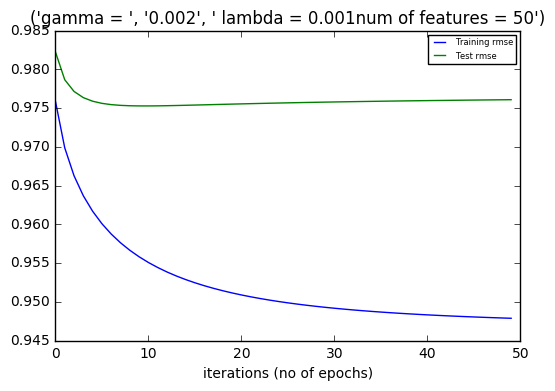

Regularization: 0.01
1.02659356319e-17 global_mu


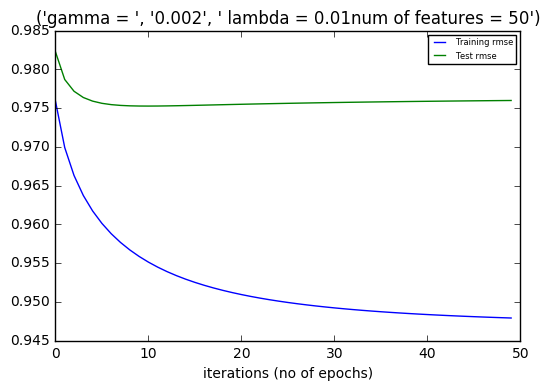

Regularization: 0.1
1.02659356319e-17 global_mu


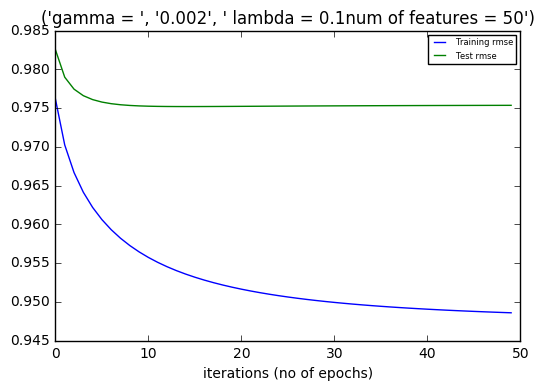

Regularization: 1.0
1.02659356319e-17 global_mu


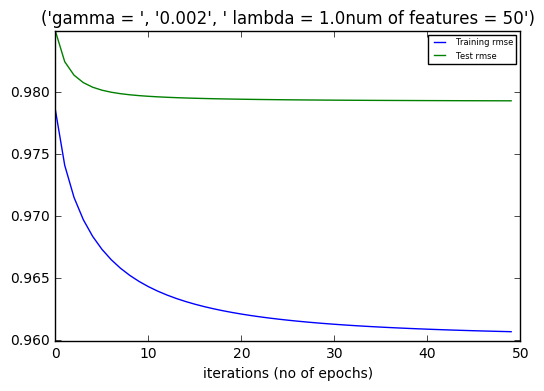

In [17]:
"Varying the lambdas:"
regularizations = [0, 0.001, 0.01, 0.1, 1.0]

for reg in regularizations:
    print('Regularization: {}'.format(reg) )

    num_features = 50
    gamma = 0.002 
    lambda_ = reg
    num_epochs = 50
    [mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
        SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc,change_step = False,param_search=True))

    plt.plot(np.arange(num_epochs),rmse_train,label= 'Training rmse')
    plt.plot(np.arange(num_epochs),rmse_test,label= 'Test rmse')

    b = 'gamma = ',str(gamma),' lambda = ' + str(reg) + 'num of features = ' + str(num_features)
    plt.title(b)
    plt.legend(loc='upper right',fontsize = 6)
    plt.xlabel('iterations (no of epochs)')
    plt.show()
    plt.close()

Varying the regularization term does not seem to create any effect on the training and test rmse values, hence we stick by setting the regularization lambda values to zero for the actual predictions.

### C. Varying the num of features:

Number of latent features: 20
1.02659356319e-17 global_mu


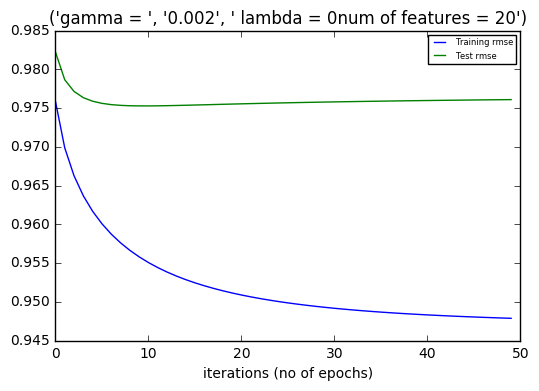

Number of latent features: 50
1.02659356319e-17 global_mu


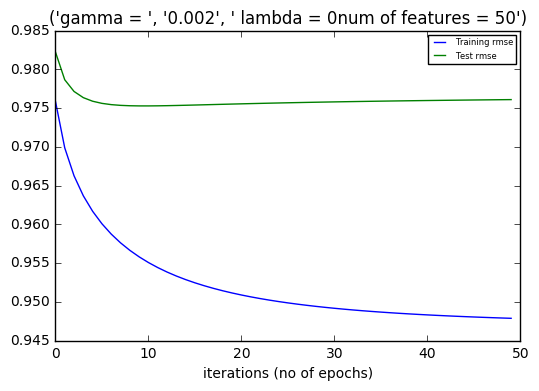

Number of latent features: 70
1.02659356319e-17 global_mu


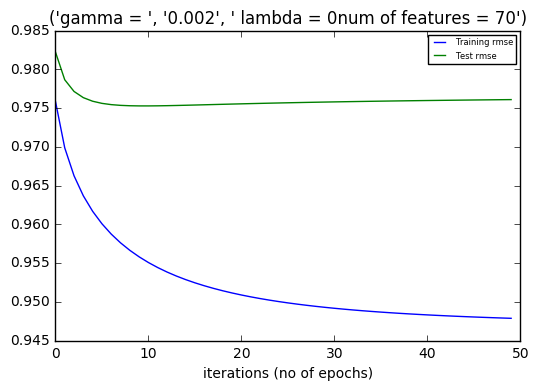

In [20]:
"Varying the num of features:"
latent_features = [20, 50, 70]

for n in latent_features:
    
    print('Number of latent features: {}'.format(n) )

    num_features = n
    gamma = 0.002 
    lambda_ = 0
    num_epochs = 50
    [mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
        SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc,change_step = False,param_search=True))

    plt.plot(np.arange(num_epochs),rmse_train,label= 'Training rmse')
    plt.plot(np.arange(num_epochs),rmse_test,label= 'Test rmse')

    b = 'gamma = ',str(gamma),' lambda = ' + str(lambda_) + 'num of features = ' + str(n)
    plt.title(b)
    plt.legend(loc='upper right',fontsize = 6)
    plt.xlabel('iterations (no of epochs)')
    plt.show()
    plt.close()

Again, we don't see a significant impact of changing the number of latent factors, we stick to 50 latent factors for our actual predictions.

### Baseline cases - 

A. Global_mean 
B. User_mean 
C. Item_mean

In [45]:
ratings = scipy.sparse.lil_matrix.todense(ratings_data)
global_mean = find_global_mean(ratings)
pred_A = global_mean*np.ones(ratings.shape)

[user_mean, item_mean] = find_mean_vectors(ratings)
pred_B = ((user_mean@np.ones((1,ratings.shape[0]))).T)
pred_C = ((item_mean@np.ones((1,ratings.shape[1]))))
print(pred_A.shape, pred_B.shape, pred_C.shape)
nz_row, nz_col = ratings.nonzero()
nz_indices = list(zip(nz_row, nz_col))
for ix,pred in enumerate([pred_A, pred_B, pred_C]):

    real_label = np.zeros(len(nz_indices))
    prediction = np.zeros(len(nz_indices))

    for i in range(len(nz_indices)):
        real_label[i] = ratings[nz_indices[i][0],nz_indices[i][1]]
        prediction[i] = pred[nz_indices[i][0],nz_indices[i][1]]

    rmse = calculate_mse(real_label, prediction) 
    print(ix+1,'RMSE score = ',rmse)


3.85728050082 global_mu
user_mean and item_mean computed!
(10000, 1000) (10000, 1000) (10000, 1000)
1 RMSE score =  1.11905673376
2 RMSE score =  1.02942067458
3 RMSE score =  1.08502915952


In the baseline cases, predicting everything equal to the global_mean returns an rmse of 1.19, while predicting the user_mean and item_mean give rmse of 1.029 and 1.085 respectively

## Making the actual predictions 

Now that we have the hyperparameters suitable for our data - 

step_size $\gamma = 0.006$, 

regularizer $\lambda = 0$, 

number of latent features = 50

We can run SGD on the actual data to find predictions.

In [49]:
# Chose submatrix from the 10000x1000 matrix
submatrix_mode = False #True #False
    
ratings = scipy.sparse.lil_matrix.todense(ratings_data)
if submatrix_mode == True:
    sub_rows = np.random.randint(0, ratings.shape[0], 2000)
    sub_cols = np.random.randint(0, ratings.shape[1], 200)
    ratings = ratings[sub_rows,:]
    ratings = ratings[:,sub_cols]

In [50]:
ratings = remove_empty_rows_and_cols(ratings)
ratings_preproc, preproc_layer, retrieve_layer = preprocess(ratings)
global_mean, user_bias_stored, item_bias_stored = find_bias_vectors(ratings_preproc)

user_mean and item_mean computed!
-7.76087242706e-18 global_mu
user_bias and item_bias computed!


In [51]:
gamma =   0.006   
num_features = 50 
lambda_ = 0  
num_epochs = 25

[mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
    SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc,change_step=False,param_search=False))
plt.plot(np.arange(num_epochs),rmse_train,label='Train rmse')
plt.plot(np.arange(num_epochs),rmse_test,label='Test rmse')
plt.legend()
plt.show()

-7.76087242706e-18 global_mu
Train rmse with initialization:  1.02434944584
gamma =  0.006
Test rmse with initialization:  1.03362240344
iter: 1, RMSE on training set: 0.9935012607247874.
iter: 1, RMSE on testing set: 1.0105262558835637.
Iteration runtime:  619.096412
iter: 2, RMSE on training set: 0.9911020952729808.
iter: 2, RMSE on testing set: 1.0108760372611139.
Iteration runtime:  601.961616
iter: 3, RMSE on training set: 0.9904057569402008.
iter: 3, RMSE on testing set: 1.0112048187627565.
Iteration runtime:  632.151422
iter: 4, RMSE on training set: 0.9901338700232595.
iter: 4, RMSE on testing set: 1.0114076274464532.
Iteration runtime:  677.964197
iter: 5, RMSE on training set: 0.990008280190908.
iter: 5, RMSE on testing set: 1.0115301667632315.
Iteration runtime:  645.305397
iter: 6, RMSE on training set: 0.9899439745577516.
iter: 6, RMSE on testing set: 1.0116069589509242.
Iteration runtime:  634.724814
iter: 7, RMSE on training set: 0.989908667755457.
iter: 7, RMSE on testi

KeyboardInterrupt: 

## Generating the submission file

In [ ]:
def create_csv_submission(prediction, submission_file_path = "submission.csv"):
    """
        Creates an output file in csv format for submission to kaggle.

        Arguments:
            prediction: matrix W * Z^T
            submission_file_path: string name of .csv output file to be created
    """

    dataset_file_path = "sampleSubmission.csv" # file path to the dataset of the entries to be predicted
    sample_ratings = load_data(dataset_file_path)
    
    # find the non-zero ratings indices 
    nz_row_sr, nz_col_sr = sample_ratings.nonzero()
    nz_sr = list(zip(nz_row_sr, nz_col_sr))
    
    def trim_values(x):
        if x < 1:
            return 1
        if x > 5:
            return 5
        return x
    
    submission_file_path = time.strftime("%Y%m%d_%H%M%S") + " " + submission_file_path
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, j in nz_sr:
            writer.writerow({'Id' : 'r' + str(i + 1) + '_' + 'c' + str(j + 1),
                             'Prediction' : str(trim_values(prediction[i, j]))})

In [ ]:
mat_pred = ( global_mean*np.ones((10000,1000)) +
           (user_bias.reshape((1000,1)).dot(np.ones((1,10000)))).T +
           (item_bias.reshape((10000,1)).dot(np.ones((1,1000)))) +
           np.dot(item_features,user_features.T) )

mat_pred_for_mse = (mat_pred + retrieve_layer)
prediction = mat_pred_for_mse
create_csv_submission(prediction)

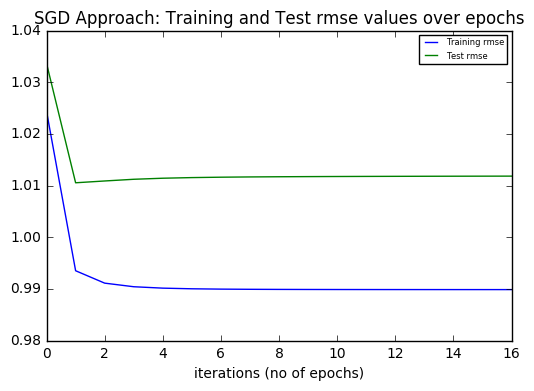

In [66]:
rmse_train = train_rmse 
rmse_test = test_rmse 
plt.plot(np.arange(17),rmse_train,label= 'Training rmse')
plt.plot(np.arange(17),rmse_test,label= 'Test rmse')
plt.title('SGD Approach: Training and Test rmse values over epochs')
plt.legend(loc='upper right',fontsize = 6)
plt.xlabel('iterations (no of epochs)')
plt.savefig('SGD_PCML_proj2.png')
plt.show()

plt.close()